# Real / Fake Job Posting Prediction Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the package

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata

from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings('ignore')

### Reading and Understanding the Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Full Stack Data Science with Python/Case Study: Fake and Real Job Advertisements Classification /fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Data overview

In [ ]:
#Check the shape of dataset
df.shape

(17880, 18)

In [ ]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
# Describe Dataset
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


This way we can quickly see basic metrics like average, median, percentile for different features

In [ ]:
# describe categorical values columns
df.describe(include = 'object').transpose()

,count,unique,top,freq
title,17880,11231,English Teacher Abroad,311
location,17534,3105,"GB, LND, London",718
department,6333,1337,Sales,551
salary_range,2868,874,0-0,142
company_profile,14572,1709,We help teachers get safe &amp; secure jobs ab...,726
description,17879,14801,"Play with kids, get paid for it Love travel? J...",379
requirements,15185,11968,University degree required. TEFL / TESOL / CEL...,410
benefits,10670,6205,See job description,726
employment_type,14409,5,Full-time,11620
required_experience,10830,7,Mid-Senior level,3809


### Data Cleaning

Data cleaning is one of the important parts of machine learning. It plays a significant part in building a model. It surely isn’t the fanciest part of machine learning and at the same time, there aren’t any hidden tricks or secrets to uncover.

If we have a well-cleaned dataset, there are chances that we can get achieve good results with simple algorithms also, which can prove very beneficial at times especially in terms of computation when the dataset size is large.

In [ ]:
# Make a copy
data=df.copy()

In [ ]:
#Look for missing values / Null values
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Filling Missing Values
df.fillna(" ",inplace = True)

In [ ]:
# Checking for duplicate
df.duplicated().sum()

0

In [ ]:
# Dropping Columns
df.drop(['salary_range','job_id'], axis = 1, inplace = True)

### Exploratory Data Analysis

#### Distrubtion of Real and Fake Jobs

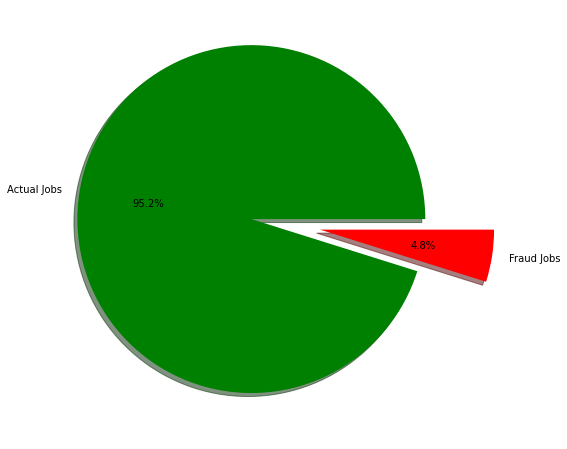

In [ ]:
plt.figure(figsize=(10,8))
labels=['Actual Jobs', 'Fraud Jobs']
explode=[.2,.2]
mycolors = ["green", "red"]
sizes=df.fraudulent.value_counts().values
plt.pie(sizes,explode,labels,autopct="%1.1f%%",shadow = True,colors = mycolors)
plt.show()

Insides :
1. There are roughly 17880 job descriptions in the dataset, with 866 of them being fraudulent. It indicates that 95.2 percent of the jobs are actual and 4.8 percent are fake.

2. The dataset is very imbalanced, with 95.2 percent of actual jobs and only 4.8 percent of fake jobs.

#### Countries with the most job openings

In [ ]:
#drop null values for better Visualization
data=data.dropna()

In [ ]:
#Visualize job postings by countries
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

Text(0.5, 0, 'Countries')

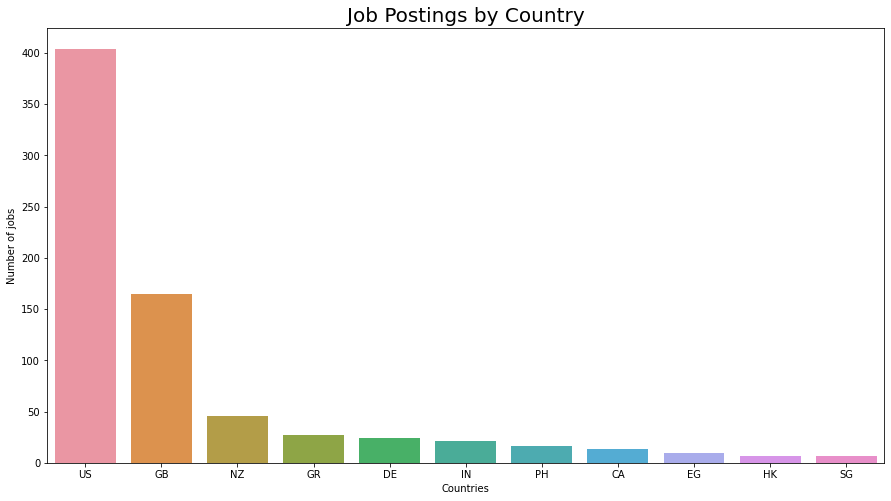

In [ ]:
plt.figure(figsize=(15, 8))
plt.tight_layout()
country=data.country.value_counts()[:11]
sns.barplot(x=country.index,y=country.values)
plt.title('Job Postings by Country', size=20)
plt.ylabel('Number of jobs', size=10)
plt.xlabel('Countries', size=10)

Insides :
  The graph above illustrates which country creates the most employment. Jobs are most prevalent in the United States, GB, and New Zealand.

#### Observations on Required Experience , Education required & Employment type for the Fake / Real  jobs

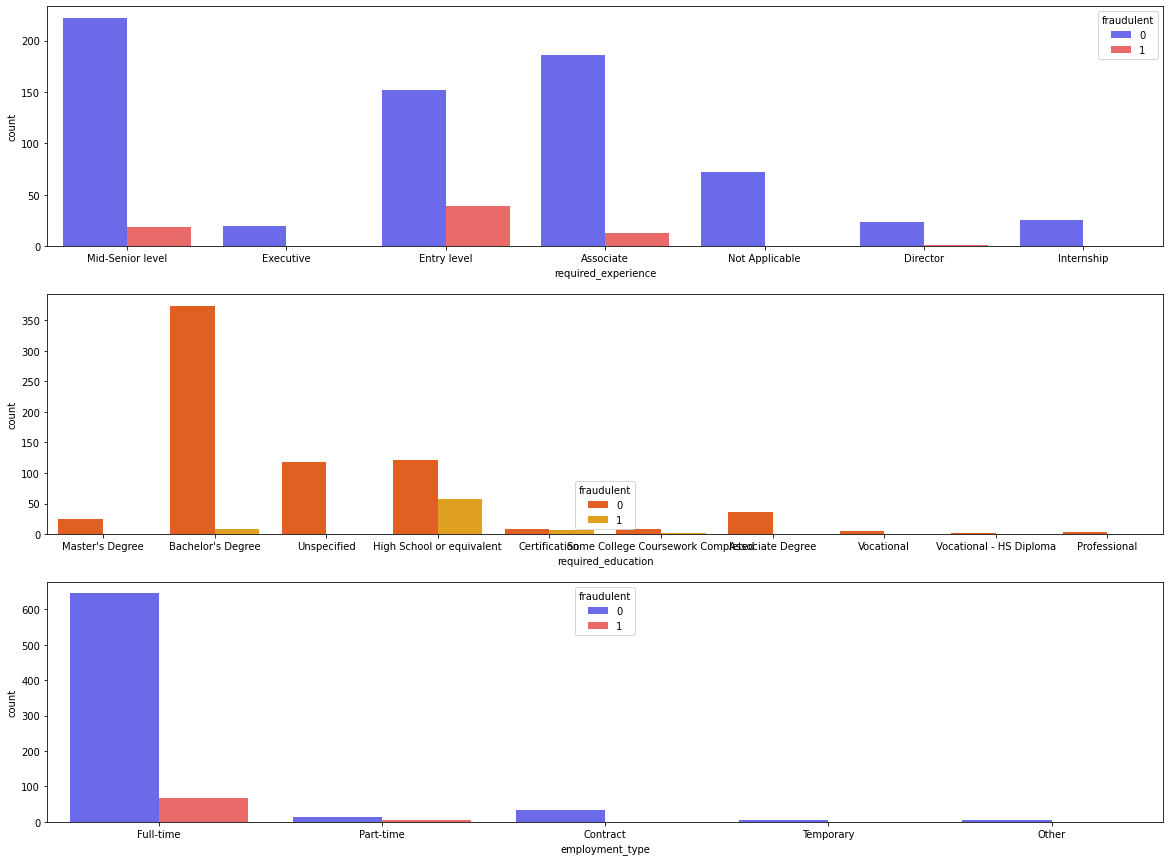

In [ ]:
# Count column plots to map the dependence of 'fraudulent' column on categorical features
fig, ax = plt.subplots(3,1, figsize=(20, 15))
sns.countplot(x='required_experience', hue='fraudulent', data=data, palette='seismic', ax=ax[0])
sns.countplot(x='required_education',hue='fraudulent', data=data, palette='autumn',ax=ax[1])
sns.countplot(x='employment_type', hue='fraudulent', data=data, palette='seismic',ax=ax[2])
plt.show()

Insides :
1. The majority of actual positions demand Mid-Senior level expertise, but the majority of fake jobs require Entry level experience.
2. We can see that the majority of actual employment demand a bachelor's degree, but the majority of fraudulent jobs just require a high school diploma or equivalent.
3. We can observe that full-time jobs make up the majority of the dataset of both actual and phoney jobs.

#### Observations on  Telecommuting, has company logo and has questions  for the Fake / Real jobs

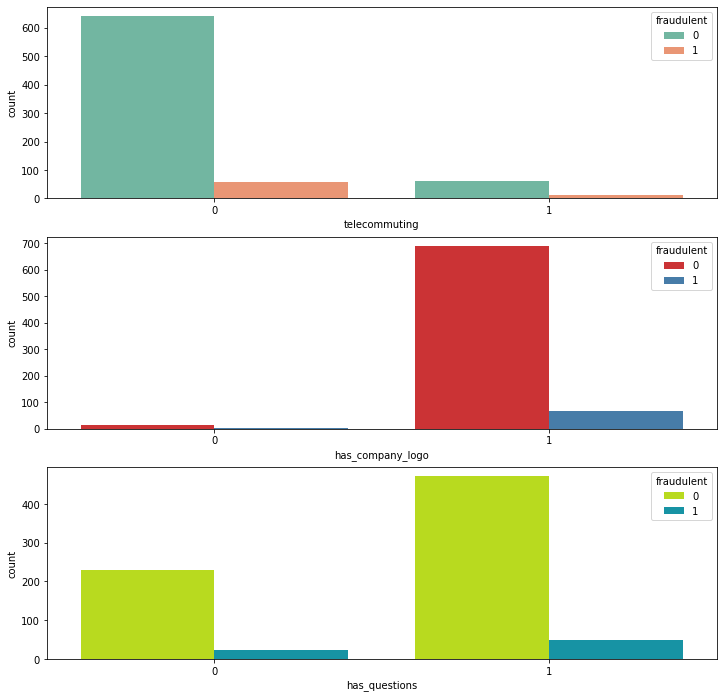

In [ ]:
# Count column plots to map the dependence of 'fraudulent' column on categorical features
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.countplot(x='telecommuting', hue='fraudulent', data=data, palette='Set2', ax=ax[0])
sns.countplot(x='has_company_logo', hue='fraudulent', data=data, palette='Set1', ax=ax[1])
sns.countplot(x='has_questions', hue='fraudulent', data=data, palette='nipy_spectral_r', ax=ax[2])
plt.show()

Insides :
1. Leading companies do not provide telecommuting so company telecommuting does not relate to job postings genuinely.
2. Around 100 fake job listings do not have a corporate logo, whereas around 680 do. Having a firm logo has nothing to do with the authenticity of job ads, as job advertisements might be fake.
3. Approximately 50 fraudulent jobs posted have no questions, whereas around 480 include questions.

### String Concatenation

String Concatenation is the technique of combining two or more strings.It’s very easy to use + operator for string concatenation. This operator can be used to add multiple strings together. However, the arguments must be a string.

In [ ]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']

In [ ]:
df.text[2]

"Commissioning Machinery Assistant (CMA) US, IA, Wever   Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry.\xa0Valor Services will be involved with you throughout every step of the hiring process and remain in contact with you all the way through the final step of signing of the employment contract with your new employer.\xa0Valor Services was founded with the vision of employing the unique skills, experiences, and qualities of America’s finest veterans to provide Private Sector companies with precise and concerted value-added services – and America’s finest Veterans with an optimized career opportunity.We are eager to get the word out to veterans that there are ample opportunities for employment in the private sector and that you are the ideal candidates to fill those positions.\xa0Valor Services\xa0Your Success is Our Mission.\xa0™\xa0 Our client, located in Houston, is actively s

In [ ]:
# Dropping Columns
df.drop(['title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function'], axis = 1, inplace = True)

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotS..."


### Lowecasing All Letters

All words changes into lower case or uppercase to avoid the duplication. Because “full” and “Full” will be considered as 2 separate words if this step is not done.

In [ ]:
df['text'] = df['text'].str.lower()
df.text[0]

"marketing intern us, ny, new york marketing we're food52, and we've created a groundbreaking and award-winning cooking site. we support, connect, and celebrate home cooks, and give them everything they need in one place.we have a top editorial, business, and engineering team. we're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. we attract the most talented home cooks and contributors in the country; we also publish well-known professionals like mario batali, gwyneth paltrow, and danny meyer. and we have partnerships with whole foods market and random house.food52 has been named the best food website by the james beard foundation and iacp, and has been featured in the new york times, npr, pando daily, techcrunch, and on the today show.we're located in chelsea, in new york city. food52, a fast-growing, james beard award-winning online food communi

### Remove Punctuation, Stopwords and Applying WordNetLemmatizer

Punctuation:
            To separate punctuation by spacing in a sentence is to get a vector representation of words.



    
Stopwords :
            Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.
  

Lemmatizer :
            Lemmatization, is an organized & step-by-step procedure of obtaining the root form of the word. It makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))
def identify_tokens(row):
    review = row
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if not w in stops]
    lemmatize_list = [lemmatizer.lemmatize(word) for word in meaningful_words]
    joined_words = (' '.join(lemmatize_list))
    return joined_words

In [ ]:
df['text'] = df['text'].apply(identify_tokens)

In [ ]:
df.text[0]

'marketing intern u ny new york marketing created groundbreaking cooking site support connect celebrate home cook give everything need one top editorial business engineering team focused using technology find new better way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish professional like mario batali gwyneth paltrow danny meyer partnership whole food market random named best food website james beard foundation iacp featured new york time npr pando daily techcrunch today located chelsea new york city james beard online food community curated recipe hub currently interviewing unpaid intern work small team editor executive developer new york city repackaging existing content number partner site huffington post yahoo buzzfeed various content management systemsresearching blog website provision affiliate programassisting affiliate program support screening affiliate assisting affil

### Separate fraud and actual jobs

The WordCloud is used to see the top occuring terms in the data to illustrate the fraud and legitimate job posts. To accomplish so, fake and actual job advertisements were divided into two text files, and WordCloud plotted them separately.

In [ ]:
fraudjobs_text = df[df.fraudulent==1].text  # Words which is fraudulent(1)
actualjobs_text = df[df.fraudulent==0].text # Words which is not fraudulent(0)

###  Common words in Fake  Jobs

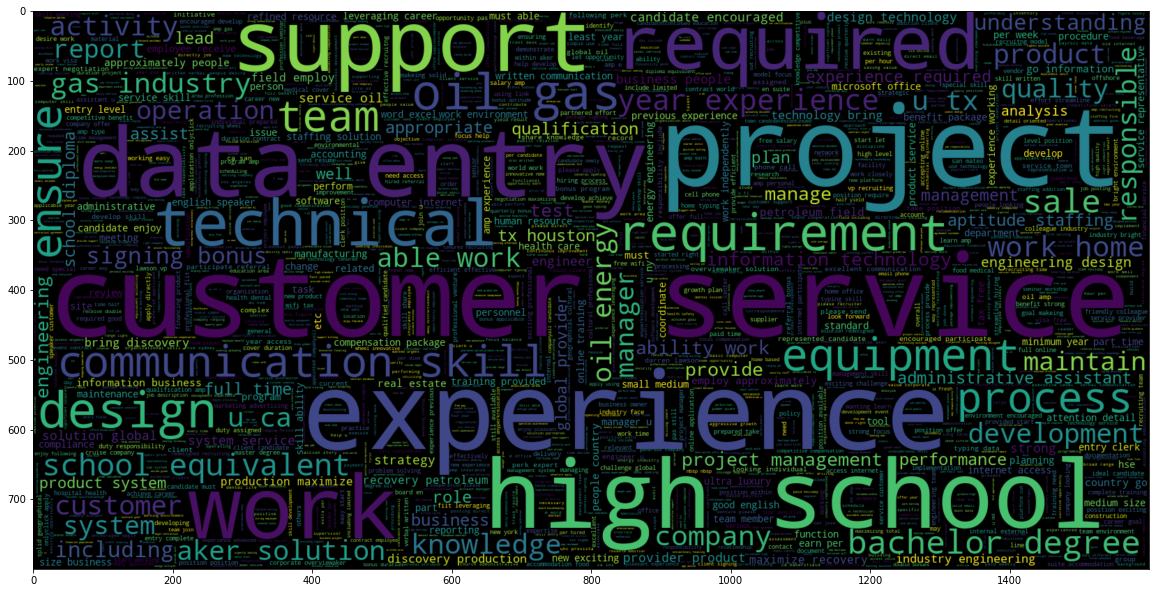

In [ ]:
#Fraudulent jobs word cloud
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(fraudjobs_text))
plt.imshow(wc , interpolation = 'bilinear')

Insides: For fake jobs, the outcome appears to be extremely revealing. The terms 'experience', 'project', 'customer', 'service', 'data', 'entry', 'school', and 'high' appear to be the most common. Those phrases appear to be far too important for fraudulent jobs.

###  Common words in Real  Jobs

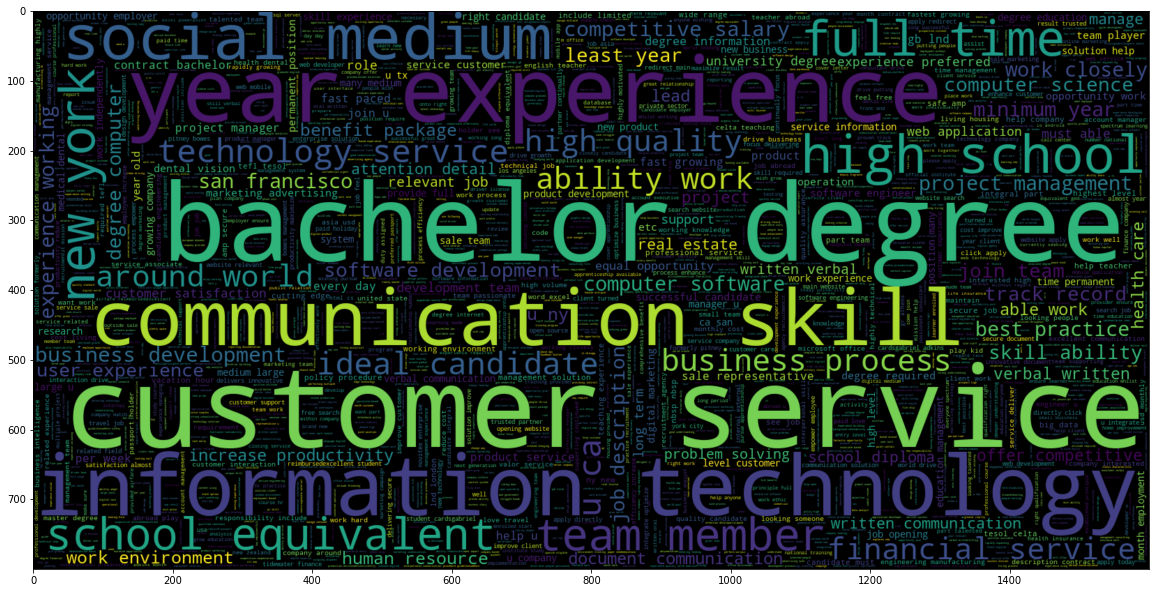

In [ ]:
#actual jobs word cloud
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(actualjobs_text))
plt.imshow(wc , interpolation = 'bilinear')

Insides: The conclusion looks to be highly enlightening for Real jobs. The phrases 'bachelor', 'degree', 'customer', 'service,'year', 'experience', 'information', and 'technology' appear to be the most commonly used. For Real jobs, such terms appear to be way too extremely important.

In [ ]:
# making copy of dataset
df1=df.copy()

## Count Vectorizer

Count Vectorizer is a way to convert a given set of strings into a frequency representation  i.e., it shows us which word occurs in a sentence and its frequency, for use in modeling such as machine learning algorithms.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(df['text']).toarray()
y = df.fraudulent

In [ ]:
# Create the dataframe
X = pd.DataFrame(X)

In [ ]:
X['telecommuting']=df['telecommuting']
X['has_company_logo']=df['has_company_logo']
X['has_questions']=df['has_questions']

### Balancing The Dataset

SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that generates synthetic samples for the minority class in an imbalanced classification dataset.
Imbalance means that the number of data points available for different classes is different. There are two classes, e.g. 90% points for one class and 10% for the other. Anything that has more the 79% and 21% ratio is said to be highly imbalanced data and they can cause serious problems to our ml models.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state = 17)

In [ ]:
x_sm, y_sm = sm.fit_resample(X, y)

### Data Spliting

In [ ]:
#Split Balance Dataset
X_train, X_test, y_train, y_test =train_test_split(x_sm, y_sm, test_size=0.3)

### Decision Tree

In [ ]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
 #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, f1_score, classification_report
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1-Score:",f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9763933783916152
F1-Score: 0.9765495767247251
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5112
           1       0.97      0.98      0.98      5097

    accuracy                           0.98     10209
   macro avg       0.98      0.98      0.98     10209
weighted avg       0.98      0.98      0.98     10209



### Random Forest Model Building

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Making Prediction

y_pred_rf = rf.predict(X_test)

In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
print("Accuracy Score: ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy Score:  0.9932412577137819
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5112
           1       0.99      0.99      0.99      5097

    accuracy                           0.99     10209
   macro avg       0.99      0.99      0.99     10209
weighted avg       0.99      0.99      0.99     10209



The model accuracy score is 0.99 in the model. It is a good score and there are more scope for improvement.

## TF-IDF model

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).

Term Frequency (TF):
                    It is the number of occurrences of a specific term in a document. Term frequency represents every text from the data as a matrix whose rows are the number of documents and columns are the number of distinct terms throughout all documents.

Inverse document frequency (IDF):
                                 It is the weight of a term, it aims to reduce the weight of a term if the term’s occurrences are scattered throughout all the documents.

In [ ]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv1 = TfidfVectorizer(max_features = 1500)
X1 = cv1.fit_transform(df1['text']).toarray()
y1 = df1.fraudulent

In [ ]:
# Create the dataframe
X1 = pd.DataFrame(X1)

In [ ]:
X1['telecommuting']=df1['telecommuting']
X1['has_company_logo']=df1['has_company_logo']
X1['has_questions']=df1['has_questions']

In [ ]:
X1.head()

,0,1,2,3,4,5,6,7,8,9,...,1493,1494,1495,1496,1497,1498,1499,telecommuting,has_company_logo,has_questions
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.267647,0.0,0.0,0.0,0,1,0
1,0.012026,0.014107,0.0,0.0,0.0,0.0,0.000000,0.000000,0.018225,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,1,0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.082556,0.078182,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,1,0
3,0.023327,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.388864,0.0,...,0.035843,0.0,0.0,0.000000,0.0,0.0,0.0,0,1,0
4,0.000000,0.034436,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.022554,0.0,0.0,0.000000,0.0,0.0,0.0,0,1,1


### Balancing The Dataset

SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that generates synthetic samples for the minority class in an imbalanced classification dataset.
Imbalance means that the number of data points available for different classes is different. There are two classes, e.g. 90% points for one class and 10% for the other. Anything that has more the 79% and 21% ratio is said to be highly imbalanced data and they can cause serious problems to our ml models.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
print("Before Balancing, counts of label '1': {}".format(sum(y1 == 1)))
print("Before Balancing, counts of label '0': {} \n".format(sum(y1 == 0)))

Before Balancing, counts of label '1': 866
Before Balancing, counts of label '0': 17014 



In [ ]:
X1.duplicated().sum()

1653

In [ ]:
sm1 = SMOTE(random_state = 17)

In [ ]:
x_sm1, y_sm1 = sm1.fit_resample(X1, y1)

In [ ]:
x_sm1.duplicated().sum()

3132

In [ ]:
print('After Balancing, the shape of train_X: {}'.format(x_sm1.shape))
print('After Balancing, the shape of train_y: {} \n'.format(y_sm1.shape))
print("After Balancing, counts of label '1': {}".format(sum(y_sm1 == 1)))
print("After Balancing, counts of label '0': {}".format(sum(y_sm1 == 0)))

After Balancing, the shape of train_X: (34028, 1503)
After Balancing, the shape of train_y: (34028,) 

After Balancing, counts of label '1': 17014
After Balancing, counts of label '0': 17014


### Data Spliting

Splitting the dataset is the next step in data preprocessing in machine learning. Every dataset for Machine Learning model must be split into two separate sets – training set and test set.

Training set denotes the subset of a dataset that is used for training the machine learning model. A test set, on the other hand, is the subset of the dataset that is used for testing the machine learning model. The ML model uses the test set to predict outcomes.

Here, the second line splits the arrays of the dataset into random train and test subsets. Here includes four variables:

x_train – features for the training data

x_test – features for the test data

y_train – dependent variables for training data

y_test – independent variable for testing data

In [ ]:
#Split Balance Dataset
X_train1, X_test1, y_train1, y_test1 =train_test_split(x_sm1, y_sm1, test_size=0.3)

### Model Building

Machine Learning models can be understood as a program that has been trained to find patterns within new data and make predictions. These models are represented as a mathematical function that takes requests in the form of input data, makes predictions on input data, and then provides an output in response.

First, these models are trained over a set of data, and then they are provided an algorithm to reason over data, extract the pattern from feed data and learn from those data. Once these models get trained, they can be used to predict the unseen dataset.

### Decision Tree

Decision tree is the most powerful and popular tool for classification and prediction. A Decision tree is a flowchart like tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

In [ ]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Create Decision Tree classifer object
clf1 = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf1 = clf1.fit(X_train1,y_train1)

In [ ]:
#Predict the response for test dataset
y_pred1 = clf1.predict(X_test1)

In [ ]:
 #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test1, y_pred1))
print("F1-Score:",f1_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

Accuracy: 0.9743363698697228
F1-Score: 0.9743639921722114
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5165
           1       0.96      0.99      0.97      5044

    accuracy                           0.97     10209
   macro avg       0.97      0.97      0.97     10209
weighted avg       0.97      0.97      0.97     10209



### Random Forest Model Building

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
rf1.fit(X_train1, y_train1)

RandomForestClassifier()

In [ ]:
# Making Prediction

y_pred_rf1 = rf1.predict(X_test1)

In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
print("Accuracy Score: ", accuracy_score(y_test1, y_pred_rf1))
print(classification_report(y_test1, y_pred_rf1))

Accuracy Score:  0.9980409442648643
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       1.00      1.00      1.00      5044

    accuracy                           1.00     10209
   macro avg       1.00      1.00      1.00     10209
weighted avg       1.00      1.00      1.00     10209



### Confusion Matrix:

A confusion matrix can be used to assess the project's quality. The goal of the project is to detect between real and fake employment.

Text(69.0, 0.5, 'Truth')

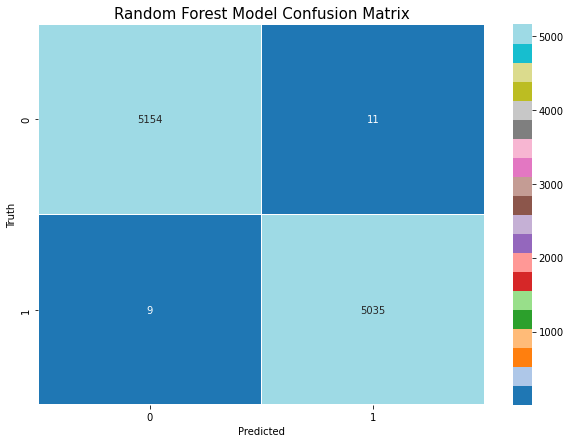

In [ ]:
# Confusion Matrix

import seaborn as sn
cm = confusion_matrix(y_test1, y_pred_rf1)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True,linewidth = 0.5 , cmap = 'tab20' , fmt='d')
plt.title('Random Forest Model Confusion Matrix', size=15)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Artificial Neural Network

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = X_train1.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               150400    
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 10)                260       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 156,996
Trainable params: 156,996
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train1, y_train1 , epochs = 5)

Epoch 1/5
745/745 [==============================] - 4s 4ms/step - loss: 0.0954 - accuracy: 0.9645
Epoch 2/5
745/745 [==============================] - 3s 4ms/step - loss: 0.0095 - accuracy: 0.9975
Epoch 3/5
745/745 [==============================] - 3s 4ms/step - loss: 0.0047 - accuracy: 0.9987
Epoch 4/5
745/745 [==============================] - 3s 4ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 5/5
745/745 [==============================] - 3s 4ms/step - loss: 6.8460e-04 - accuracy: 0.9999


In [ ]:
pred_cv = model.predict(X_test1)
pred_cv[:5]

320/320 [==============================] - 1s 2ms/step


array([[1.2969596e-12],
       [1.0303982e-15],
       [9.9999958e-01],
       [9.9999249e-01],
       [1.4775697e-10]], dtype=float32)

In [ ]:
pred_cv = np.around(pred_cv , decimals = 0)
pred_cv[:5]

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
accuracy_score(pred_cv,y_test1)

0.9944166911548633

In [ ]:
cv_report = classification_report(y_test1,pred_cv,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5165
           1       0.99      1.00      0.99      5044

    accuracy                           0.99     10209
   macro avg       0.99      0.99      0.99     10209
weighted avg       0.99      0.99      0.99     10209



In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test1,pred_cv, average=None)

0.9944820909970958

Text(0.5, 1.0, 'Artificial Neural Network Confusion Matrix')

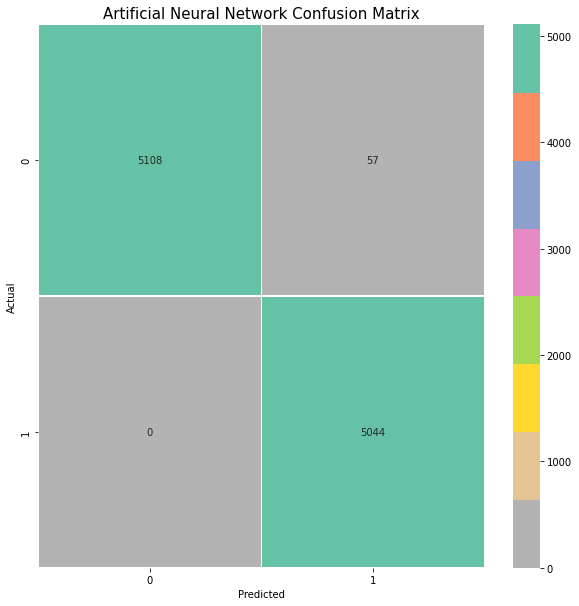

In [ ]:
cm_cv = confusion_matrix(y_test1,pred_cv)
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,annot = True,linewidth = 0.5 , cmap = 'Set2_r' , fmt='d')
plt.title('Artificial Neural Network Confusion Matrix', size=15)

In [ ]:
input_text = ["new product development project leader us, oh, cincinnati provide full time permanent positions many medium large us companies. interested finding/recruiting high quality candidates it, engineering, manufacturing highly technical non-technical jobs. (we 1500 job openings website relevant job. feel free search website apply directly. click “apply now” redirect main website search jobs.)location - atlanta, ga, usajob type – permanentjob requirements &amp; responsibilities –specific responsibilitiescoordination project management new product development projects:act team leader perform project management duties new product development projects leading cross functional teams defined gated npd process.lead cross functional teams development project timeline maintain throughout life project. periodically present status project management.facilitate coordinate project activities minimize project timelines.assign alternate members find alternative resources personally complete project tasks team members absent unable complete tasks per timeline.develop manage project budget team including development expense capital tooling expense tooling.guide team develop new products meet cost targets. primarily responsible creating preliminary product cost estimates conjunction engineering. primarily responsible accuracy preliminary cost estimates final costing products.define roles &amp; responsibilities team members undefined processes new processes created unique instances occur.manage collection project data npd process gate exits release shipment documents.facilitate team meetings record meeting minutes.connect members appropriate personnel including manufacturing test labs legal etc.drive team manufacturing personnel supply chain towards time completion pilot build inventory build.education experience requirementsbachelor science degree engineering (or applicable four year degree) minimum eight years experience project management product design process engineering manufacturing engineering. alternately fifteen years experience proven ability related field work environment. experience managing projects working cross-functional team environment and/or functioning project team leader required. strong organizational communication skills required.visit - #url_ec64af2b4fe2ca316e828f93b0cd098c22f8beba98dcac09d4dd7384b221a5e8#-#url_2954b76adf23051d4bc35fc729f5a18c5de715ed82dfaee24b3aabbf3874ca57#"]
input_telecommuting = 1
input_has_company_logo = 0
input_has_questions = 1


# convert text to feature vectors
input_data_features = cv1.transform(input_text)
data_features = pd.DataFrame(input_data_features.toarray())
data_features['telecommuting']=input_telecommuting
data_features['has_company_logo']=input_has_company_logo
data_features['has_questions']=input_has_questions

# making prediction

prediction = rf1.predict(data_features)
print(prediction)


if (prediction[0]==1):
    print('Fraudulant Job')

else:
    print('Real Job')

[0]
Real Job
